<a href="https://colab.research.google.com/github/Virajkd/Lab1/blob/main/Data_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost XlsxWriter

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: catboost in c:\users\prana\appdata\local\programs\python\python311\lib\site-packages (1.2.5)



Splitting of code snippets

In [ ]:
import pandas as pd
import re

def categorize_java_code(code):
    categories = {
        "Basic_Syntax_Elements": [],
        "Control_Flow_Structures": [],
        "Method_Declarations": [],
        "Class_and_Object_Instantiation": [],
        "Complex_Expressions": [],
        "Libraries_Imports": [],
        "Custom_Data_Structures": [],
    }

    # Basic Syntax Elements
    basic_syntax_keywords = r"\b(if|else|for|while|int|String|boolean|char|double|float|byte|short|long|=|\+|-|\*|/|%)\b"
    categories["Basic_Syntax_Elements"] = re.findall(basic_syntax_keywords, code)

    # Control Flow Structures
    control_flow_keywords = r"\b(for|while|if|else|switch|case|break|continue)\b"
    categories["Control_Flow_Structures"] = re.findall(control_flow_keywords, code)

    # Method Declarations
    method_declaration_pattern = r"\b(public|private|protected|static)?\s*(void|int|String|boolean|char|double|float|byte|short|long|[A-Za-z_]\w*)\s+([A-Za-z_]\w*)\s*\(.*\)\s*\{"
    method_matches = re.findall(method_declaration_pattern, code)
    categories["Method_Declarations"] = [match[2] for match in method_matches]

    # Class and Object Instantiation
    object_creation_pattern = r"\bnew\s+([A-Za-z_]\w*)"
    class_pattern = r"\bclass\s+[A-Za-z_]\w*\s*\{.*?\}"  # Non-greedy match for the full class content
    class_matches = re.findall(class_pattern, code, re.DOTALL)
    object_matches = re.findall(object_creation_pattern, code)
    categories["Class_and_Object_Instantiation"] = object_matches
    categories["Custom_Data_Structures"] = class_matches

    # Complex Expressions
    complex_expressions_patterns = r"\b(for\s*\(.*\).*\{|\bwhile\s*\(.*\).*\{|\bif\s*\(.*\).*\{|\belse\s*\{|\bswitch\s*\(.*\)\s*\{)"
    categories["Complex_Expressions"] = re.findall(complex_expressions_patterns, code)

    # Libraries/Imports
    libraries_imports_pattern = r"\bimport\s+([A-Za-z_]\w*(\.[A-Za-z_]\w*)*)\s*;"
    categories["Libraries_Imports"] = [match[0] for match in re.findall(libraries_imports_pattern, code)]

    # Merge all relevant categories into "Keywords"
    combined_keywords = (
        categories["Basic_Syntax_Elements"]
        + categories["Control_Flow_Structures"]
        + categories["Method_Declarations"]
        + categories["Class_and_Object_Instantiation"]
        +categories["Complex_Expressions"]
    )
    categories["Keywords"] = combined_keywords + categories["Libraries_Imports"]
    # Convert lists to strings, or '0' if empty
    for key in categories:
        categories[key] = ', '.join(categories[key]) if categories[key] else '0'

    return categories

def process_excel_file(file_path):
    df = pd.read_excel(file_path)

    # Initialize Keywords and Custom_Data_Structures columns
    df["Keywords"] = '0'
    df["Custom_Data_Structures"] = '0'

    # Iterate over rows and update the "Keywords" and "Custom_Data_Structures" columns
    for index, row in df.iterrows():
        code = row['Code_with_Error']
        categories = categorize_java_code(code)

        # Update the DataFrame with Keywords and Custom_Data_Structures
        df.at[index, "Keywords"] = categories["Keywords"]
        df.at[index, "Custom_Data_Structures"] = categories["Custom_Data_Structures"]

    # Save the modified DataFrame to a new Excel file
    df.to_excel("comb_vsp_java_v4.xlsx", index=False)

# Process the file
process_excel_file("VSP - Java_v3.xlsx")


Vectorization of split code and code with no split

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer

# Load the CodeT5+ model and tokenizer
checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

# Function to encode data in batches with dynamic dimension handling
def encode_data_batch(data, model, tokenizer, device):
    embeddings = []
    for code in data:
        inputs = tokenizer.encode(code, return_tensors="pt", max_length=512, truncation=True).to(device)
        with torch.no_grad():
            # Obtain the embedding from the model output
            output = model(inputs)[0]

            # If the output is 3D (batch_size, seq_len, hidden_dim), apply mean over seq_len dimension
            if output.dim() == 3:
                embedding = output.mean(dim=1).cpu().numpy()
            # If the output is already 2D (batch_size, hidden_dim), no need to apply mean
            else:
                embedding = output.cpu().numpy()

        embeddings.append(embedding)

    # Concatenate embeddings if they are nested
    return np.vstack(embeddings)

def process_to_vectors(input_file, output_file):
    df = pd.read_excel(input_file)

    # Columns to process for embeddings
    component_columns = ["Keywords", "Custom_Data_Structures"]

    all_embeddings = pd.DataFrame()

    for column in component_columns:
        # Process each component and obtain embeddings
        embeddings = encode_data_batch(df[column].fillna(""), model, tokenizer, device)
        embeddings_df = pd.DataFrame(embeddings, columns=[f"{column}_Vector_{i}" for i in range(embeddings.shape[1])])

        # Concatenate embeddings for each column
        all_embeddings = pd.concat([all_embeddings, embeddings_df], axis=1)

    # Add the target column
    all_embeddings["Final_Marks"] = df["Final_Marks"]

    # Save to Excel file
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        all_embeddings.to_excel(writer, sheet_name='Embeddings', index=False)

    print(f"Embeddings for each category saved to {output_file}")

# Process and save embeddings
process_to_vectors("comb_vsp_java_v4.xlsx", "CE2_vector.xlsx")



KeyboardInterrupt: 

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer

# Load the CodeT5+ model and tokenizer
checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

# Function to encode data in batches with dynamic dimension handling
def encode_data_batch(data, model, tokenizer, device):
    embeddings = []
    for code in data:
        inputs = tokenizer.encode(code, return_tensors="pt", max_length=512, truncation=True).to(device)
        with torch.no_grad():
            # Obtain the embedding from the model output
            output = model(inputs)[0]

            # If the output is 3D (batch_size, seq_len, hidden_dim), apply mean over seq_len dimension
            if output.dim() == 3:
                embedding = output.mean(dim=1).cpu().numpy()
            # If the output is already 2D (batch_size, hidden_dim), no need to apply mean
            else:
                embedding = output.cpu().numpy()

        embeddings.append(embedding)

    # Concatenate embeddings if they are nested
    return np.vstack(embeddings)

def process_code_with_error(input_file, output_file):
    # Load the input data
    df = pd.read_excel(input_file)

    # Ensure the column exists
    if "Code_with_Error" not in df.columns:
        raise ValueError("The column 'Code_with_Error' is missing in the input file.")

    # Process the 'Code_with_Error' column and generate embeddings
    embeddings = encode_data_batch(df["Code_with_Error"].fillna(""), model, tokenizer, device)

    # Create a DataFrame for embeddings
    embeddings_df = pd.DataFrame(embeddings, columns=[f"Code_with_Error_Vector_{i}" for i in range(embeddings.shape[1])])

    # Add the target column (if applicable)
    if "Final_Marks" in df.columns:
        embeddings_df["Final_Marks"] = df["Final_Marks"]

    # Save embeddings to Excel
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        embeddings_df.to_excel(writer, sheet_name='Embeddings', index=False)

    print(f"Embeddings for 'Code_with_Error' saved to {output_file}")

# Process and save embeddings for 'Code_with_Error'
process_code_with_error("comb_vsp_java_v4.xlsx", "no_splitting.xlsx")


Embeddings for 'Code_with_Error' saved to no_splitting.xlsx


EDA for generated embeddings

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Columns: 513 entries, Keywords_Vector_0 to Final_Marks
dtypes: float64(512), int64(1)
memory usage: 4.8 MB
None


Missing Values:
Keywords_Vector_0                    0
Keywords_Vector_1                    0
Keywords_Vector_2                    0
Keywords_Vector_3                    0
Keywords_Vector_4                    0
                                    ..
Custom_Data_Structures_Vector_252    0
Custom_Data_Structures_Vector_253    0
Custom_Data_Structures_Vector_254    0
Custom_Data_Structures_Vector_255    0
Final_Marks                          0
Length: 513, dtype: int64


Descriptive Statistics:
                                    count      mean       std       min  \
Keywords_Vector_0                  1232.0 -0.033176  0.039842 -0.181972   
Keywords_Vector_1                  1232.0 -0.025381  0.042759 -0.151570   
Keywords_Vector_2                  1232.0 -0.076756  0.044569 -0.228018   
K

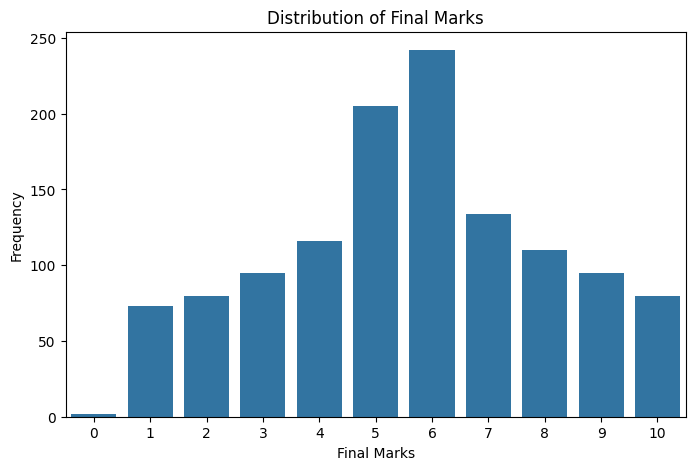

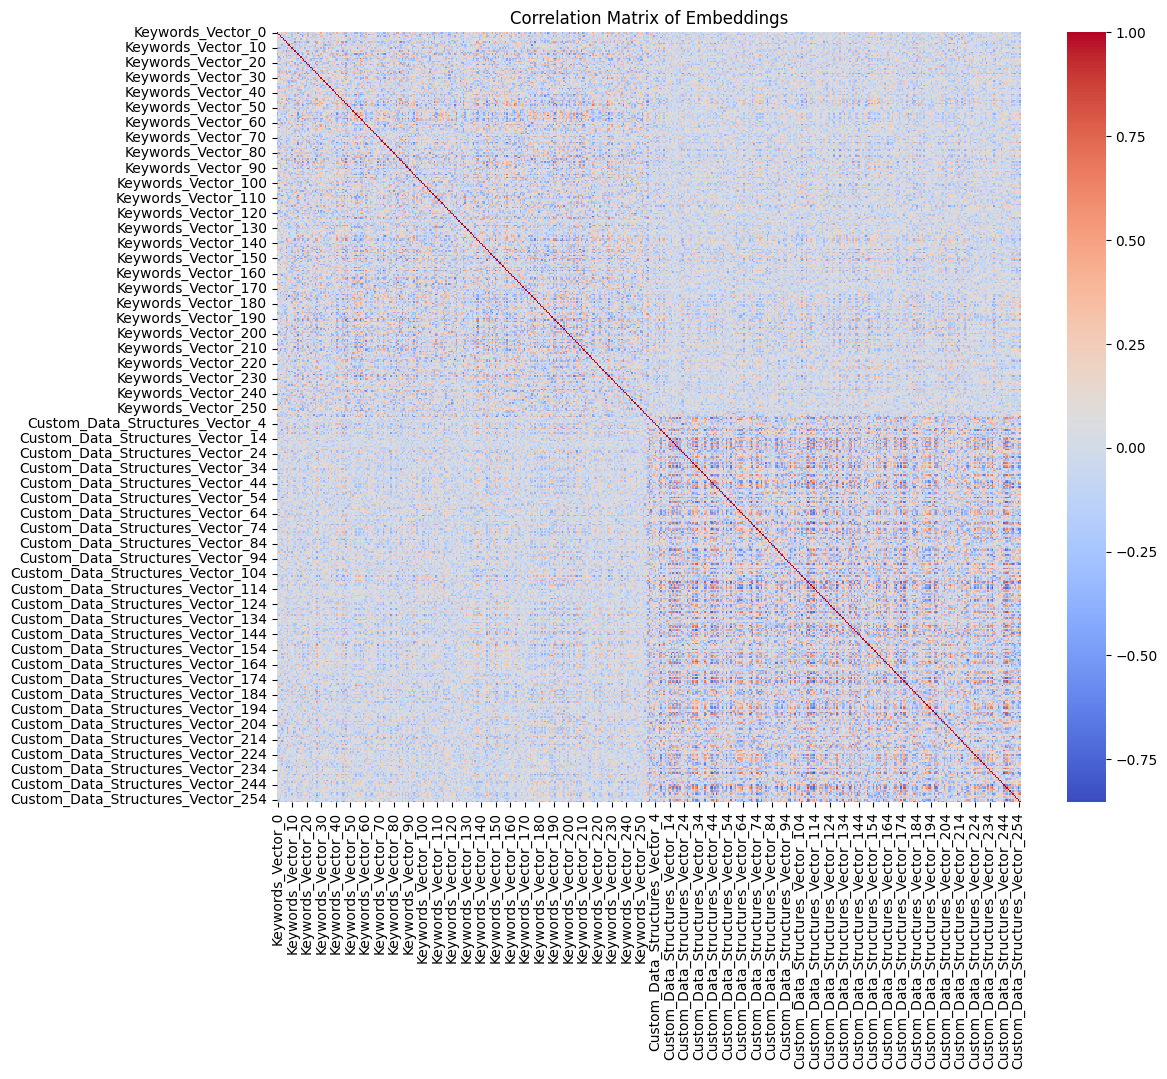

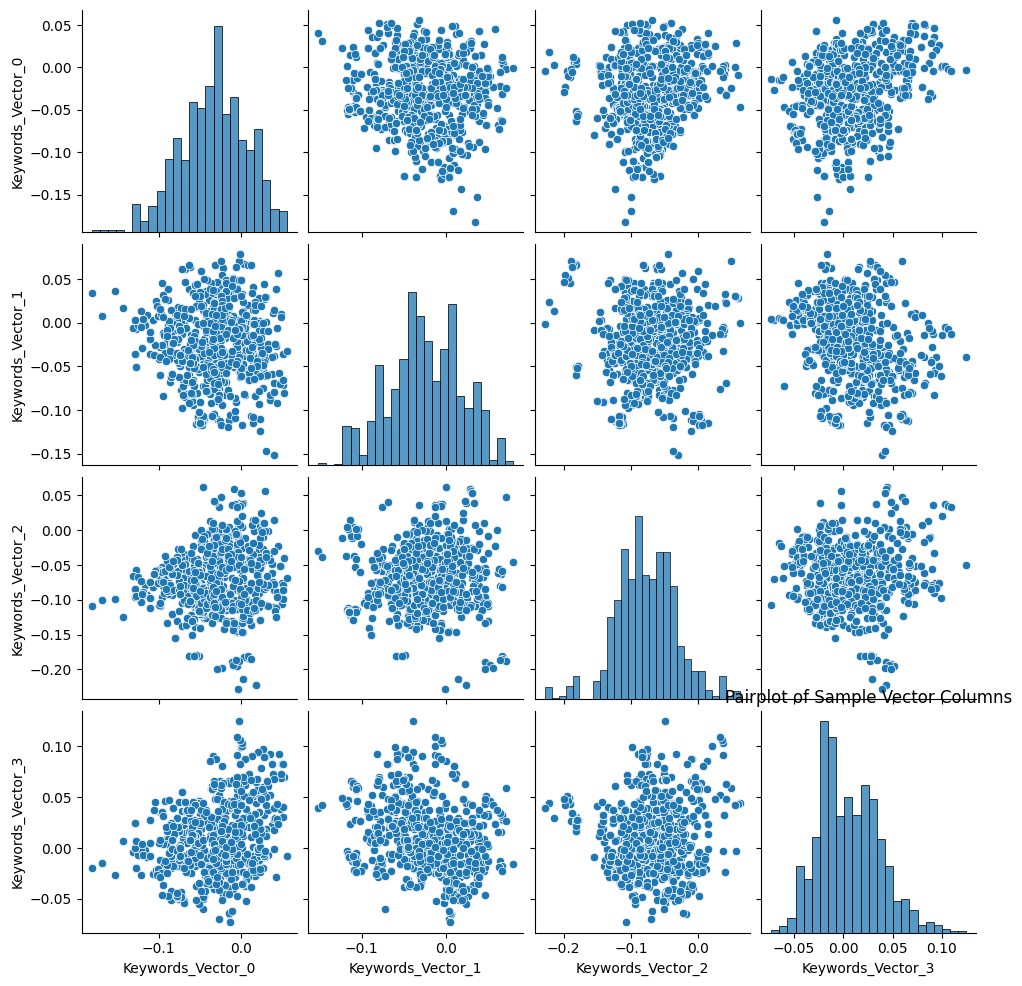

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def perform_eda(file_path):

    # Load the dataset
    df = pd.read_excel(file_path)

    # Print basic info about the dataset
    print("Dataset Info:")
    print(df.info())
    print("\n")

    # Check for missing values
    print("Missing Values:")
    print(df.isnull().sum())
    print("\n")

    # Descriptive statistics
    print("Descriptive Statistics:")
    print(df.describe().T)
    print("\n")

    # Variance of each column
    print("Feature Variance:")
    variance = df.var()
    print(variance)
    print("\n")

    # Distribution of the target variable
    if "Final_Marks" in df.columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=df["Final_Marks"])
        plt.title("Distribution of Final Marks")
        plt.xlabel("Final Marks")
        plt.ylabel("Frequency")
        plt.show()

    # Heatmap of feature correlations (only vector columns)
    vector_columns = [col for col in df.columns if "Vector_" in col]
    if len(vector_columns) > 1:
        plt.figure(figsize=(12, 10))
        corr_matrix = df[vector_columns].corr()
        sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", cbar=True)
        plt.title("Correlation Matrix of Embeddings")
        plt.show()

    # Pairplot for reduced dimensions (if applicable)
    if len(vector_columns) > 4:  # Limit to first 4 columns for visualization
        sample_vectors = vector_columns[:4]
        sns.pairplot(df[sample_vectors])
        plt.title("Pairplot of Sample Vector Columns")
        plt.show()

perform_eda("CE2_vector.xlsx")

PCA reduction to size 20 with finding explained variance

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_excel('CE2_vector.xlsx')
keywords = df[[f'Keywords_Vector_{i}' for i in range(256)]]
custom_data_structures = df[[f'Custom_Data_Structures_Vector_{i}' for i in range(256)]]
final_marks = df["Final_Marks"]

# Apply PCA to reduce both vectors to 20 dimensions and compute explained variance
def apply_pca_and_get_variance(data, n_components=20):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    explained_variance = sum(pca.explained_variance_ratio_) * 100  # Total explained variance in percentage
    return reduced_data, explained_variance, pca.explained_variance_ratio_

# Reduce keywords vector and compute explained variance
reduced_keywords, variance_keywords, variance_ratios_keywords = apply_pca_and_get_variance(keywords, n_components=20)

# Reduce custom data structures vector and compute explained variance
reduced_custom_data_structures, variance_custom, variance_ratios_custom = apply_pca_and_get_variance(custom_data_structures, n_components=20)

# Print explained variance
print(f"Explained Variance for Keywords (20 components): {variance_keywords:.2f}%")

print(f"Explained Variance for Custom Data Structures (20 components): {variance_custom:.2f}%")

# Convert reduced data to DataFrame and save to Excel
reduced_df = pd.DataFrame(reduced_keywords, columns=[f'Keywords_Vector_{i}' for i in range(20)])
reduced_df = pd.concat(
    [reduced_df, pd.DataFrame(reduced_custom_data_structures, columns=[f'Custom_Data_Structures_Vector_{i}' for i in range(20)])],
    axis=1
)
reduced_df["Final_Marks"] = final_marks

# Save to Excel
reduced_df.to_excel("pca.xlsx", index=False)
print("PCA-reduced vectors and explained variance saved to pca.xlsx.")


Explained Variance for Keywords (20 components): 80.45%
Explained Variance for Custom Data Structures (20 components): 88.81%
PCA-reduced vectors and explained variance saved to pca.xlsx.


Reduction based on information gain

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def select_top_features_based_on_info_gain(input_file, output_file, target_column="Final_Marks", top_n=20):
    # Load the dataset
    df = pd.read_excel(input_file)

    # Extract features and target
    keywords = df[[f'Keywords_Vector_{i}' for i in range(256)]]
    custom_data_structures = df[[f'Custom_Data_Structures_Vector_{i}' for i in range(256)]]
    final_marks = df[target_column]

    # Calculate information gain (mutual information) for each feature with respect to the target
    info_gain_keywords = mutual_info_regression(keywords, final_marks)
    info_gain_custom_data = mutual_info_regression(custom_data_structures, final_marks)

    # Get indices of top `top_n` features based on information gain
    top_keywords_indices = info_gain_keywords.argsort()[-top_n:][::-1]
    top_custom_data_indices = info_gain_custom_data.argsort()[-top_n:][::-1]

    # Select top features
    top_keywords = keywords.iloc[:, top_keywords_indices]
    top_custom_data_structures = custom_data_structures.iloc[:, top_custom_data_indices]

    # Rename columns for clarity
    top_keywords.columns = [f'Keywords_Vector_{i}' for i in range(top_n)]
    top_custom_data_structures.columns = [f'Custom_Data_Structures_Vector_{i}' for i in range(top_n)]

    # Combine reduced features with the target column
    reduced_df = pd.concat([top_keywords, top_custom_data_structures], axis=1)
    reduced_df[target_column] = final_marks

    # Save to Excel
    reduced_df.to_excel(output_file, index=False)
    print(f"Top {top_n} features based on information gain saved to {output_file}.")

# Example usage
select_top_features_based_on_info_gain(input_file='CE2_vector.xlsx', output_file='IG.xlsx')


Top 20 features based on information gain saved to IG.xlsx.


Visualization

In [ ]:
import pandas as pd

# Load the Excel files
source_file = "VSP - Java_v3.xlsx"  # File containing the 'Questions' column
destination_file = "CE2__visu.xlsx"  # File to which the column will be added

# Load the DataFrames
source_df = pd.read_excel(source_file)
destination_df = pd.read_excel(destination_file)

# Ensure the 'Questions' column exists in the source file
if "Question" in source_df.columns:
    # Add the 'Questions' column to the destination DataFrame
    destination_df["Question"] = source_df["Question"]

    # Save the updated destination file
    destination_df.to_excel("CE2__visu.xlsx", index=False)
    print("The 'Question' column has been added and saved to")


The 'Question' column has been added and saved to


In [ ]:
import pandas as pd

# Load the Excel files
source_file = "VSP - Java_v3.xlsx"  # File containing the 'Questions' column
destination_file = "og_visu.xlsx"  # File to which the column will be added

# Load the DataFrames
source_df = pd.read_excel(source_file)
destination_df = pd.read_excel(destination_file)

# Ensure the 'Questions' column exists in the source file
if "Question" in source_df.columns:
    # Add the 'Questions' column to the destination DataFrame
    destination_df["Question"] = source_df["Question"]

    # Save the updated destination file
    destination_df.to_excel("og_visu.xlsx", index=False)
    print("The 'Question' column has been added and saved to")


The 'Question' column has been added and saved to


no splitting

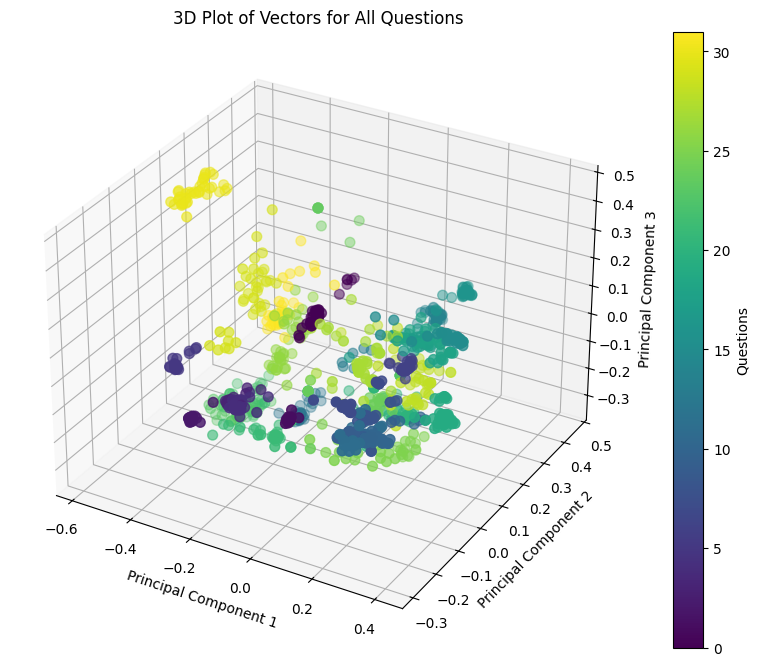

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = "og_visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns
vector_columns = [col for col in df.columns if "Vector_" in col]

# Extract the unique questions
unique_questions = df["Question"].unique()

# Extract vectors for all questions
vectors = []
labels = []

# Create a mapping for questions to numeric labels
question_to_label = {question: idx for idx, question in enumerate(unique_questions)}

for question in unique_questions:
    filtered_df = df[df["Question"] == question]
    question_vectors = filtered_df[vector_columns].values
    vectors.append(question_vectors)
    labels.extend([question_to_label[question]] * len(question_vectors))

# Concatenate all vectors into a single array
all_vectors = np.vstack(vectors)

# Apply PCA for 3D reduction
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(all_vectors)

# Plot the vectors in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with numeric labels for color mapping
scatter = ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], c=np.array(labels), cmap='viridis', marker='o', s=50)

# Add axis labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# Add title
ax.set_title("3D Plot of Vectors for All Questions")

# Add color bar for the question labels
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Questions')

# Show plot
plt.show()


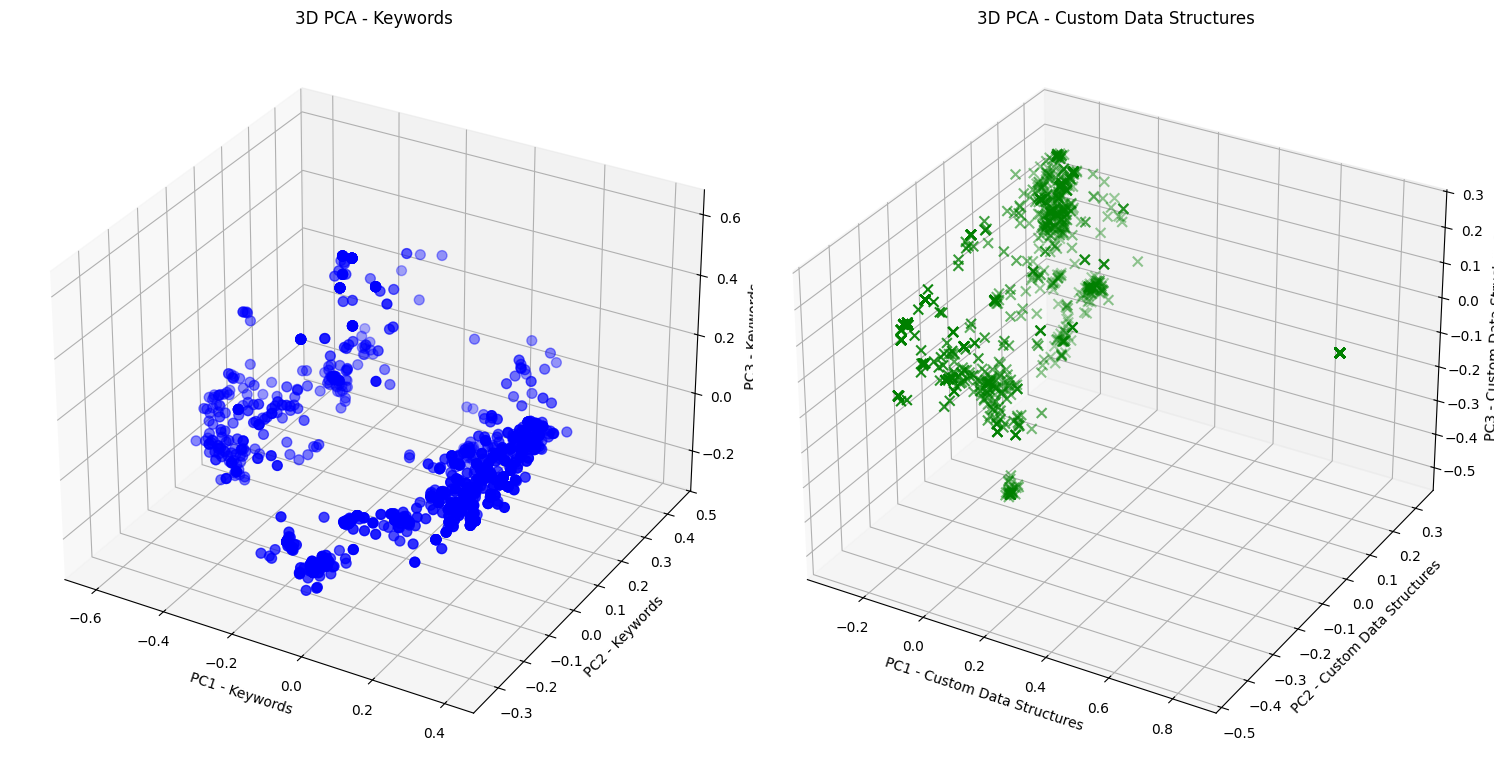

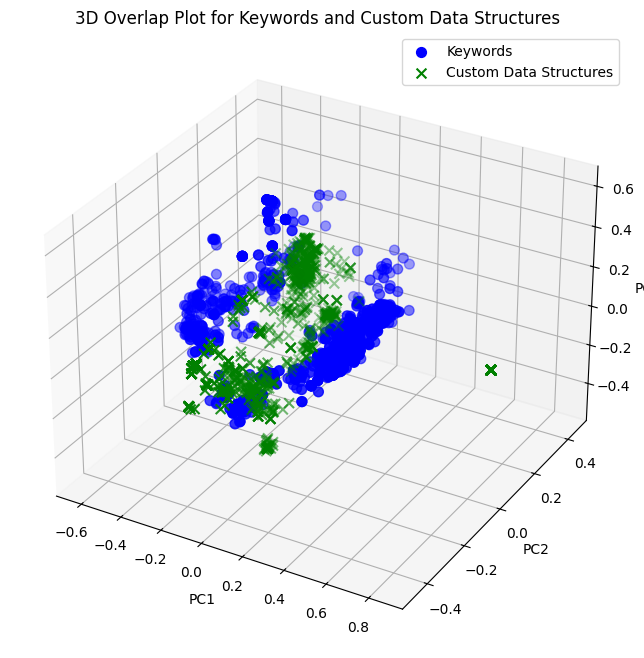

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the vector data for all rows
keywords_vectors = df[keywords_columns].values
custom_data_vectors = df[custom_data_columns].values

# Reduce Keywords vectors to 3 dimensions using PCA
pca_keywords = PCA(n_components=3)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors)

# Reduce Custom Data Structures vectors to 3 dimensions using PCA
pca_custom_data = PCA(n_components=3)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors)

# Create figure for the plots
fig = plt.figure(figsize=(15, 10))

# Plot for Keywords (3D)
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], reduced_keywords[:, 2], c='blue', marker='o', s=50)
ax1.set_xlabel("PC1 - Keywords")
ax1.set_ylabel("PC2 - Keywords")
ax1.set_zlabel("PC3 - Keywords")
ax1.set_title("3D PCA - Keywords")

# Plot for Custom Data Structures (3D)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], reduced_custom_data[:, 2], c='green', marker='x', s=50)
ax2.set_xlabel("PC1 - Custom Data Structures")
ax2.set_ylabel("PC2 - Custom Data Structures")
ax2.set_zlabel("PC3 - Custom Data Structures")
ax2.set_title("3D PCA - Custom Data Structures")

# Show individual plots
plt.tight_layout()
plt.show()

# Combined Overlap Plot (3D) for all data points
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot overlap of Keywords and Custom Data Structures
ax.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], reduced_keywords[:, 2], c='blue', marker='o', s=50, label='Keywords')
ax.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], reduced_custom_data[:, 2], c='green', marker='x', s=50, label='Custom Data Structures')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D Overlap Plot for Keywords and Custom Data Structures")
ax.legend()

# Show the combined overlap plot
plt.show()


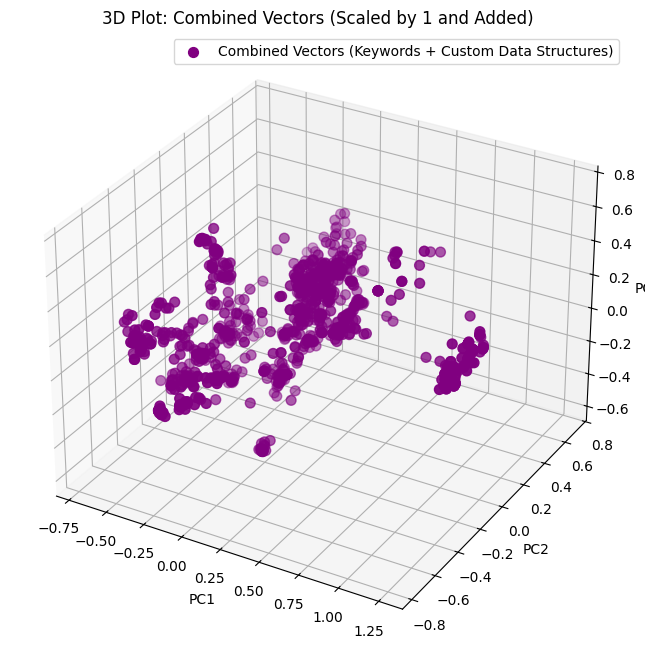

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the vector data for all rows
keywords_vectors = df[keywords_columns].values
custom_data_vectors = df[custom_data_columns].values

# Reduce Keywords vectors to 3 dimensions using PCA
pca_keywords = PCA(n_components=3)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors)

# Reduce Custom Data Structures vectors to 3 dimensions using PCA
pca_custom_data = PCA(n_components=3)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors)

# Scale both categories by 1 (which does not change their values)
scaled_keywords = reduced_keywords * 1
scaled_custom_data = reduced_custom_data * 1

# Add the scaled vectors element-wise
combined_vectors = scaled_keywords + scaled_custom_data

# Create figure for the plot
fig = plt.figure(figsize=(12, 8))

# Plot the combined vectors (added Keywords and Custom Data Structures) in 3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_vectors[:, 0], combined_vectors[:, 1], combined_vectors[:, 2], c='purple', marker='o', s=50, label='Combined Vectors (Keywords + Custom Data Structures)')

# Set axis labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D Plot: Combined Vectors (Scaled by 1 and Added)")

# Show the plot
ax.legend()
plt.show()


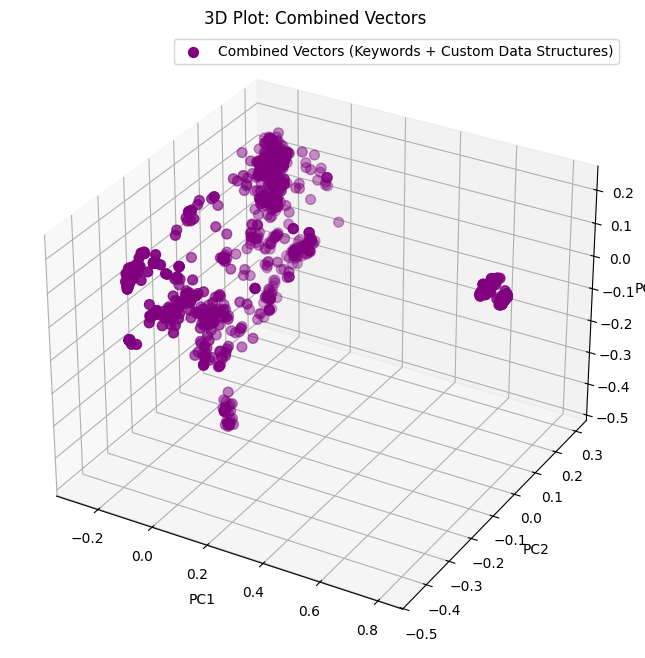

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the vector data for all rows
keywords_vectors = df[keywords_columns].values
custom_data_vectors = df[custom_data_columns].values

# Reduce Keywords vectors to 3 dimensions using PCA
pca_keywords = PCA(n_components=3)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors)

# Reduce Custom Data Structures vectors to 3 dimensions using PCA
pca_custom_data = PCA(n_components=3)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors)

# Scale both categories by 1 (which does not change their values)
scaled_keywords = reduced_keywords * 0.1
scaled_custom_data = reduced_custom_data * 0.9

# Add the scaled vectors element-wise
combined_vectors = scaled_keywords + scaled_custom_data

# Create figure for the plot
fig = plt.figure(figsize=(12, 8))

# Plot the combined vectors (added Keywords and Custom Data Structures) in 3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_vectors[:, 0], combined_vectors[:, 1], combined_vectors[:, 2], c='purple', marker='o', s=50, label='Combined Vectors (Keywords + Custom Data Structures)')

# Set axis labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D Plot: Combined Vectors ")

# Show the plot
ax.legend()
plt.show()


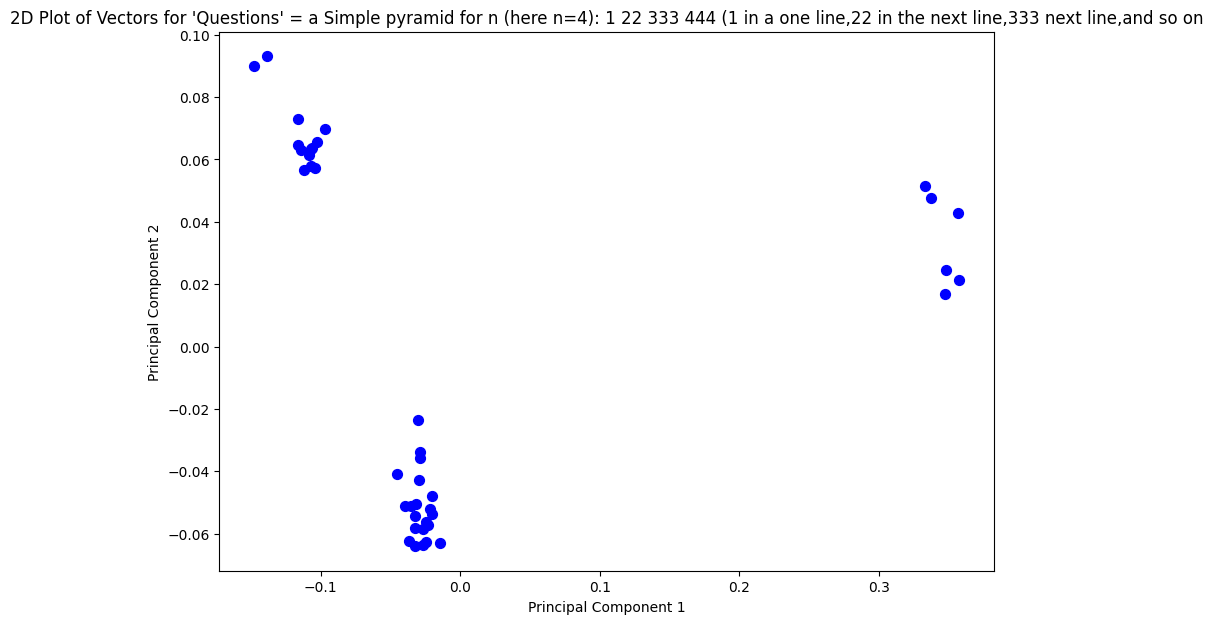

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = "og_visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns
vector_columns = [col for col in df.columns if "Vector_" in col]

# Extract the "Questions" value from the first row
first_question_value = df.loc[0, "Question"]

# Filter rows where the "Questions" value matches the first row
filtered_df = df[df["Question"] == first_question_value]

# Extract the vectors
vectors = filtered_df[vector_columns].values

# Reduce vectors to 2D using PCA (if needed)
if vectors.shape[1] > 2:
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
else:
    vectors_2d = vectors

# Plot the vectors in 2D
plt.figure(figsize=(10, 7))

# Scatter plot
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', marker='o', s=50)

# Add axis labels
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add title
plt.title(f"2D Plot of Vectors for 'Questions' = {first_question_value}")

# Show plot
plt.show()


concatenation(no scaling)

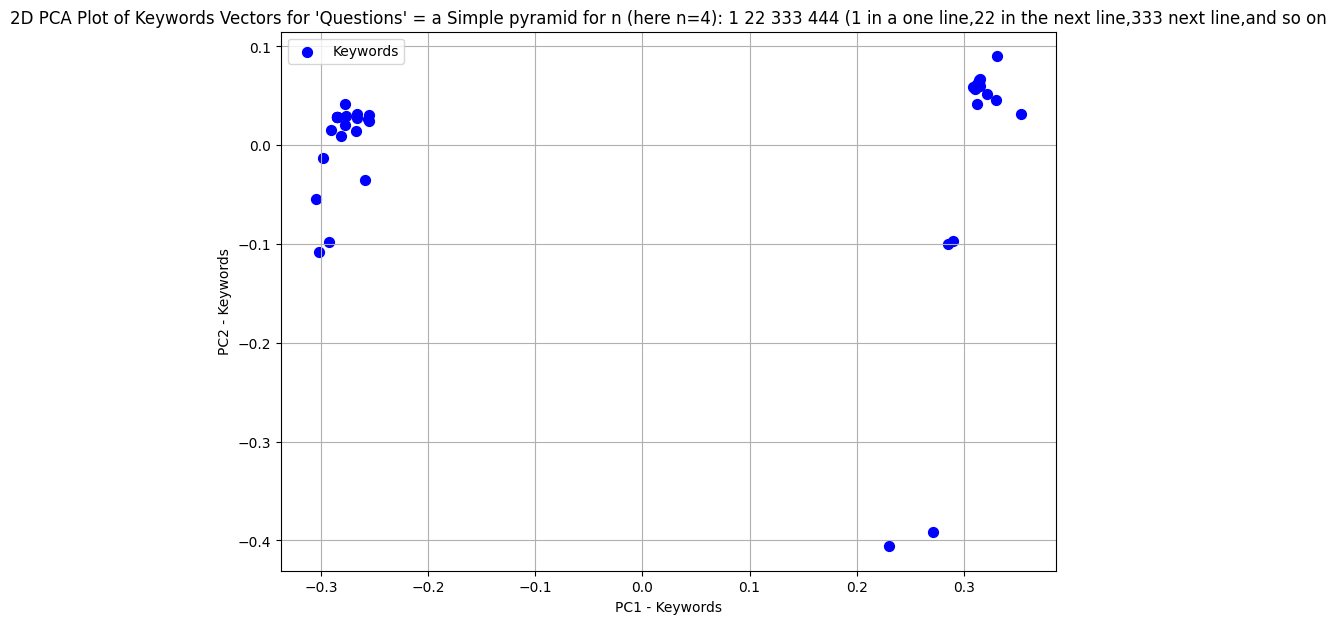

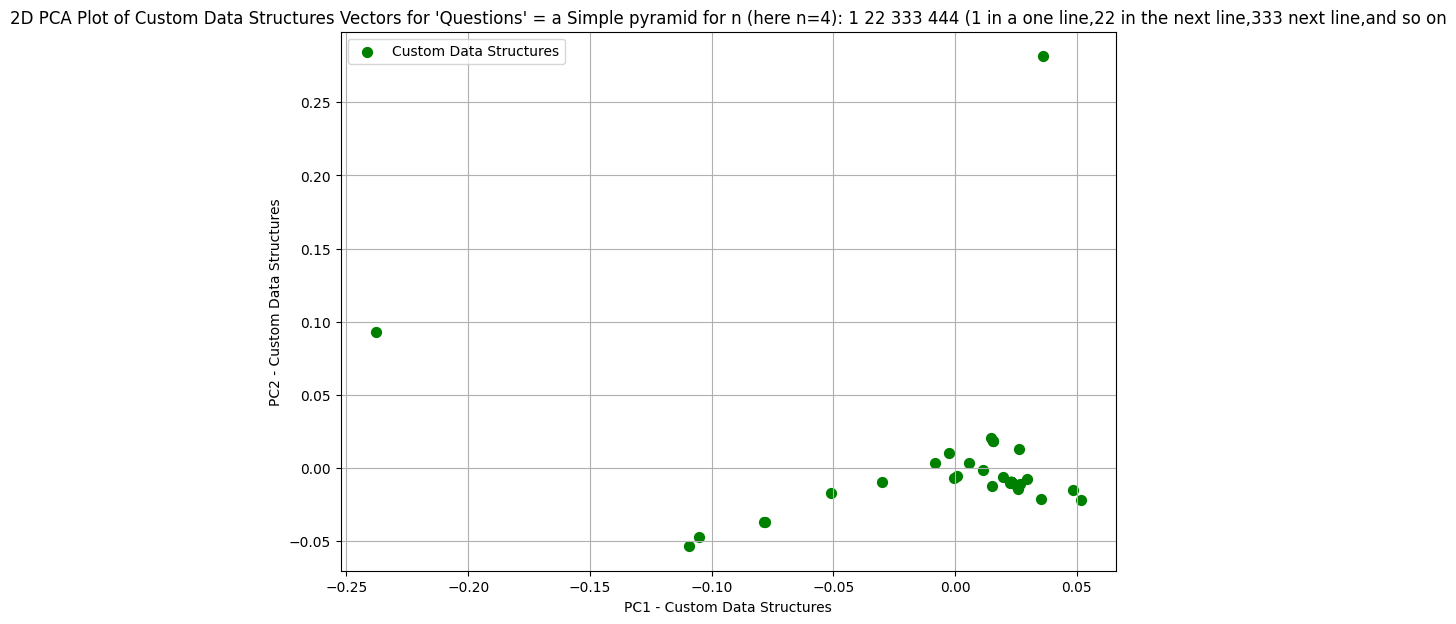

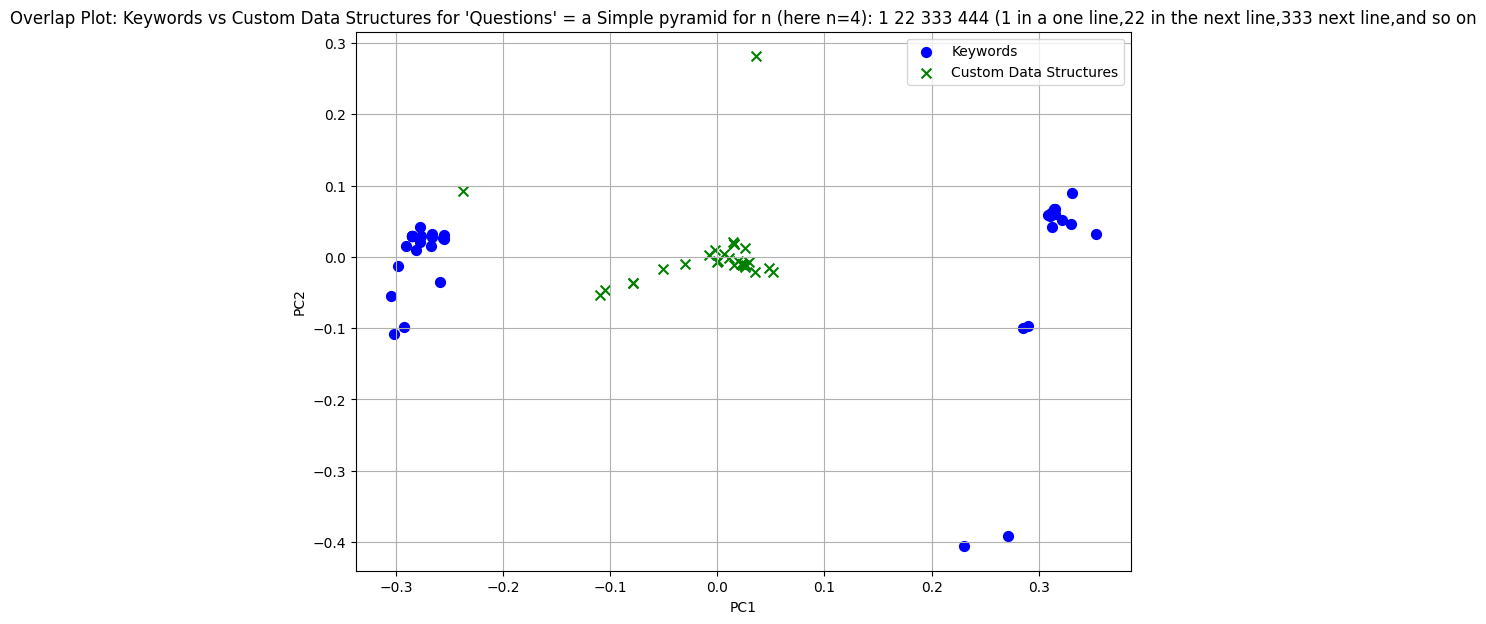

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the "Questions" value from the first row
first_question_value = df.loc[0, "Question"]

# Filter rows where the "Questions" value matches the first row
filtered_df = df[df["Question"] == first_question_value]

# Extract the vector data
keywords_vectors = filtered_df[keywords_columns].values
custom_data_vectors = filtered_df[custom_data_columns].values

# Reduce Keywords vectors to 2 dimensions using PCA
pca_keywords = PCA(n_components=2)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors)

# Reduce Custom Data Structures vectors to 2 dimensions using PCA
pca_custom_data = PCA(n_components=2)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors)

# Plot for Keywords
plt.figure(figsize=(10, 7))
plt.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], c='blue', marker='o', s=50, label='Keywords')
plt.xlabel("PC1 - Keywords")
plt.ylabel("PC2 - Keywords")
plt.title(f"2D PCA Plot of Keywords Vectors for 'Questions' = {first_question_value}")
plt.grid()
plt.legend()
plt.show()

# Plot for Custom Data Structures
plt.figure(figsize=(10, 7))
plt.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], c='green', marker='o', s=50, label='Custom Data Structures')
plt.xlabel("PC1 - Custom Data Structures")
plt.ylabel("PC2 - Custom Data Structures")
plt.title(f"2D PCA Plot of Custom Data Structures Vectors for 'Questions' = {first_question_value}")
plt.grid()
plt.legend()
plt.show()

# Combined Overlap Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], c='blue', marker='o', s=50, label='Keywords')
plt.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], c='green', marker='x', s=50, label='Custom Data Structures')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Overlap Plot: Keywords vs Custom Data Structures for 'Questions' = {first_question_value}")
plt.grid()
plt.legend()
plt.show()

concatenation with scaling

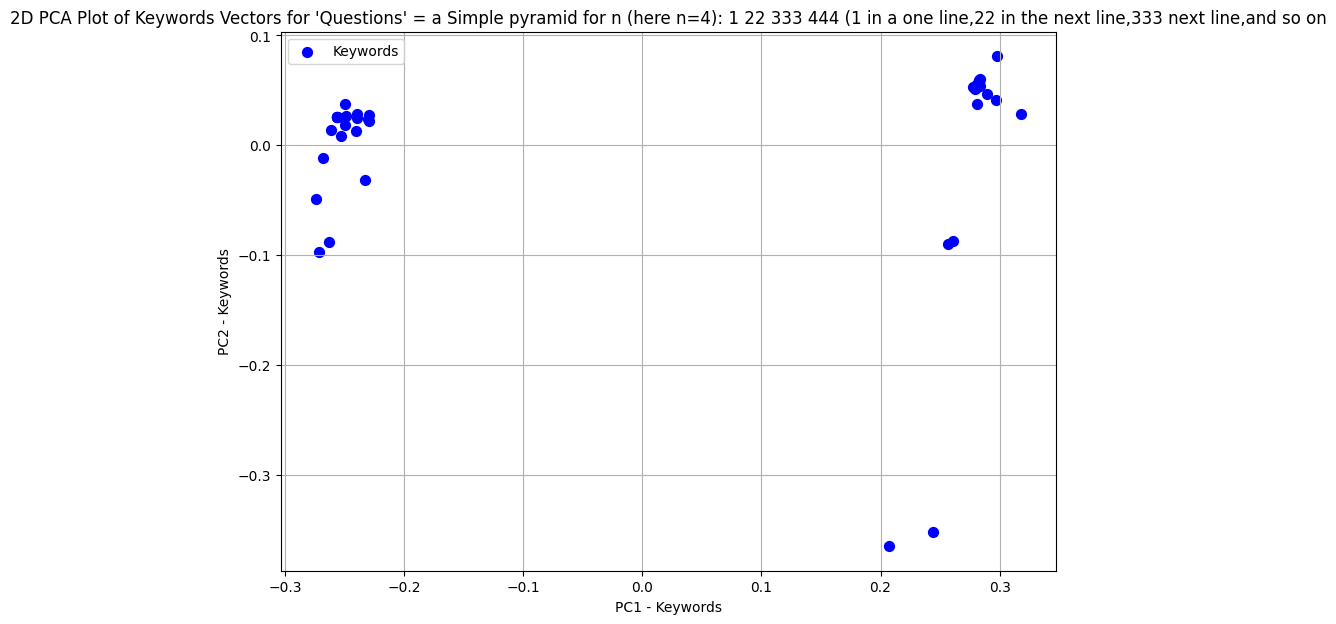

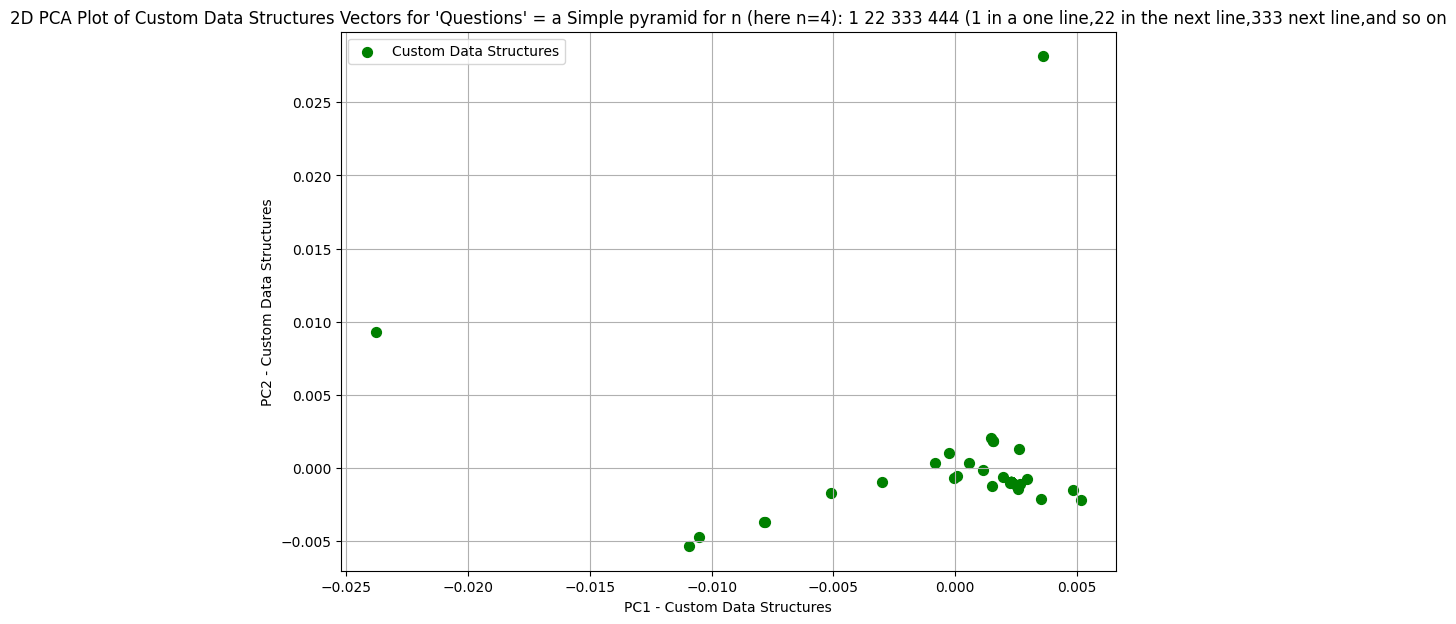

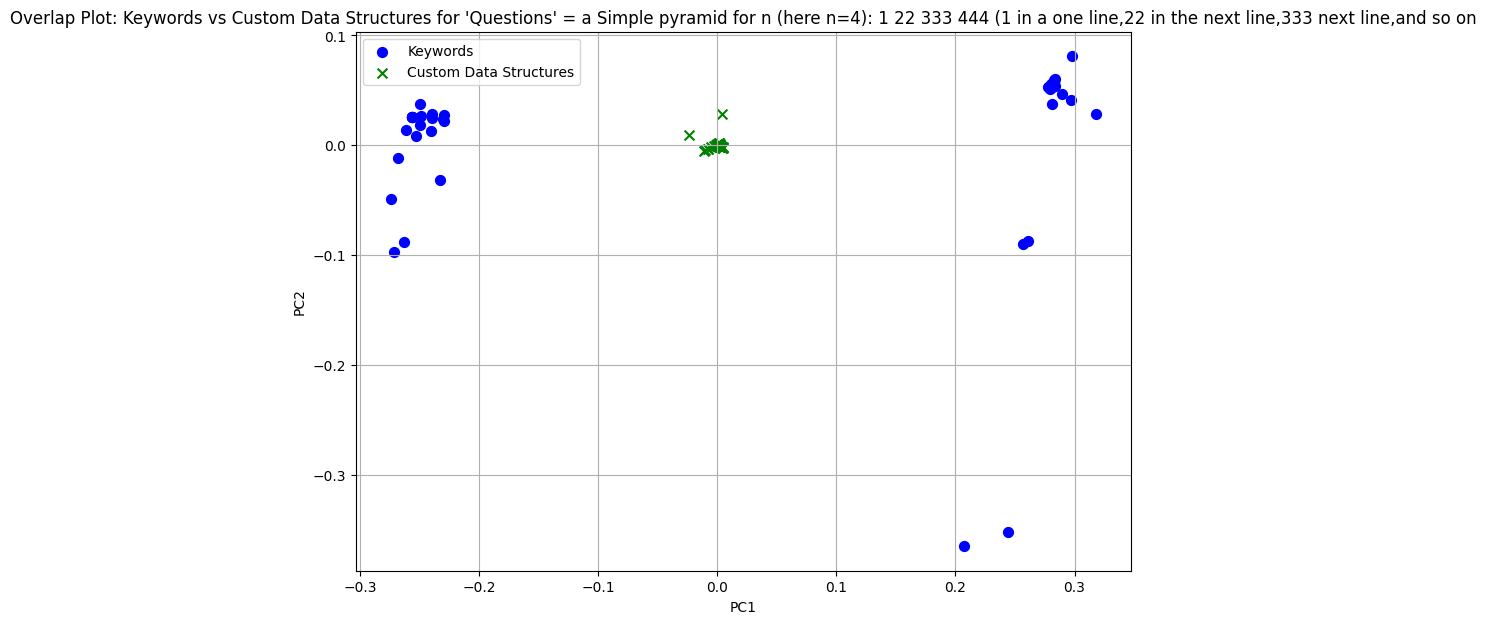

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the "Questions" value from the first row
first_question_value = df.loc[0, "Question"]

# Filter rows where the "Questions" value matches the first row
filtered_df = df[df["Question"] == first_question_value]

# Extract the vector data
keywords_vectors = filtered_df[keywords_columns].values
custom_data_vectors = filtered_df[custom_data_columns].values

# Reduce Keywords vectors to 2 dimensions using PCA
pca_keywords = PCA(n_components=2)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors)
reduced_keywords=reduced_keywords*0.9
# Reduce Custom Data Structures vectors to 2 dimensions using PCA
pca_custom_data = PCA(n_components=2)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors)
reduced_custom_data=reduced_custom_data*0.1
# Plot for Keywords
plt.figure(figsize=(10, 7))
plt.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], c='blue', marker='o', s=50, label='Keywords')
plt.xlabel("PC1 - Keywords")
plt.ylabel("PC2 - Keywords")
plt.title(f"2D PCA Plot of Keywords Vectors for 'Questions' = {first_question_value}")
plt.grid()
plt.legend()
plt.show()

# Plot for Custom Data Structures
plt.figure(figsize=(10, 7))
plt.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], c='green', marker='o', s=50, label='Custom Data Structures')
plt.xlabel("PC1 - Custom Data Structures")
plt.ylabel("PC2 - Custom Data Structures")
plt.title(f"2D PCA Plot of Custom Data Structures Vectors for 'Questions' = {first_question_value}")
plt.grid()
plt.legend()
plt.show()

# Combined Overlap Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], c='blue', marker='o', s=50, label='Keywords')
plt.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], c='green', marker='x', s=50, label='Custom Data Structures')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Overlap Plot: Keywords vs Custom Data Structures for 'Questions' = {first_question_value}")
plt.grid()
plt.legend()
plt.show()

addition(no scaling)

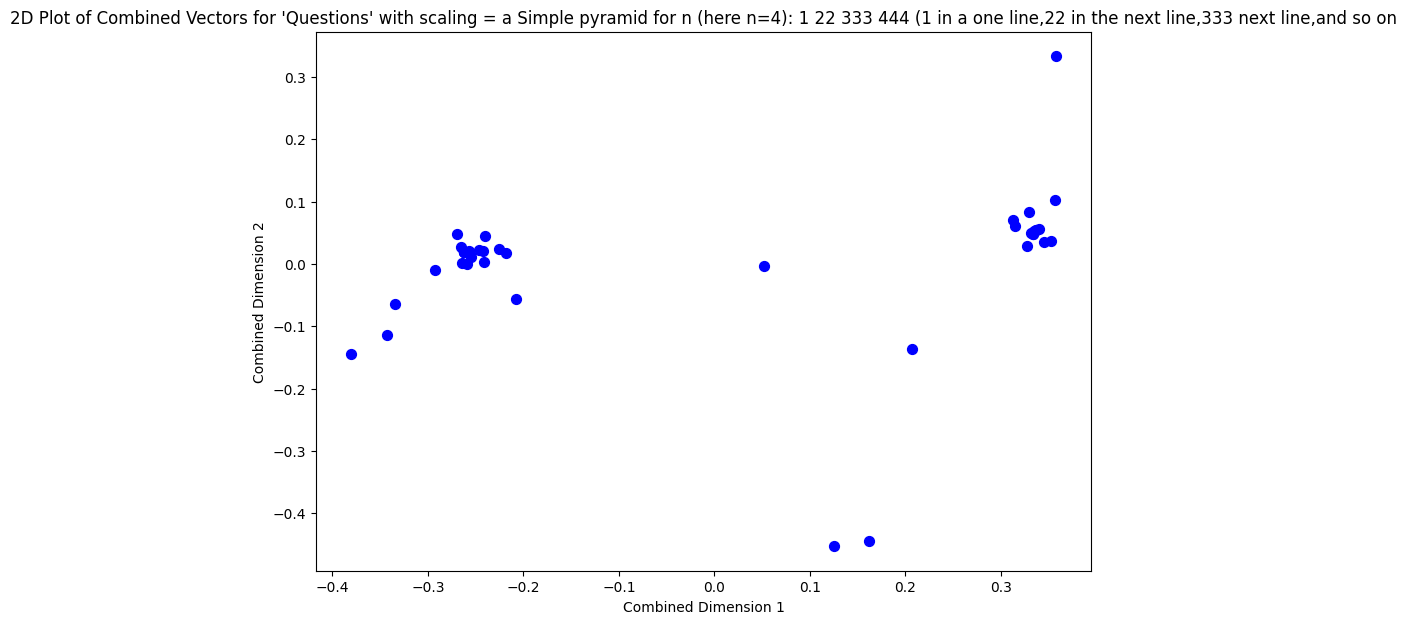

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the "Questions" value from the first row
first_question_value = df.loc[0, "Question"]

# Filter rows where the "Questions" value matches the first row
filtered_df = df[df["Question"] == first_question_value]

# Extract the vector data
keywords_vectors = filtered_df[keywords_columns].values
custom_data_vectors = filtered_df[custom_data_columns].values

# Reduce each set of vectors to 2 dimensions using PCA
pca_keywords = PCA(n_components=2)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors) *1  # Apply scaling

pca_custom_data = PCA(n_components=2)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors) * 1 # Apply scaling

# Add the reduced vectors to form a new 2D representation
combined_2d = reduced_keywords + reduced_custom_data

# Plot the 2D data
plt.figure(figsize=(10, 7))

# Scatter plot
plt.scatter(combined_2d[:, 0], combined_2d[:, 1], c='blue', marker='o', s=50)

# Add axis labels
plt.xlabel("Combined Dimension 1")
plt.ylabel("Combined Dimension 2")

# Add title
plt.title(f"2D Plot of Combined Vectors for 'Questions' with scaling = {first_question_value}")

# Show plot
plt.show()


addition with scaling

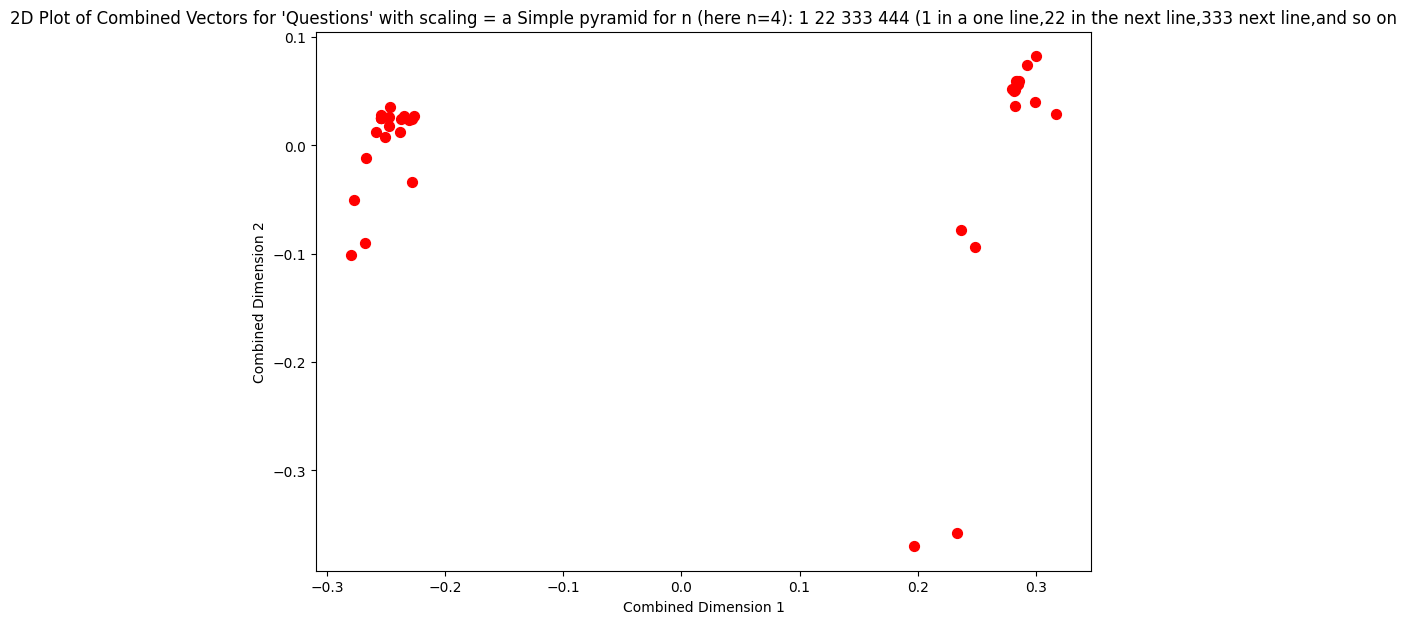

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract the "Questions" value from the first row
first_question_value = df.loc[0, "Question"]

# Filter rows where the "Questions" value matches the first row
filtered_df = df[df["Question"] == first_question_value]

# Extract the vector data
keywords_vectors = filtered_df[keywords_columns].values
custom_data_vectors = filtered_df[custom_data_columns].values

# Reduce each set of vectors to 2 dimensions using PCA
pca_keywords = PCA(n_components=2)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors) * 0.9  # Apply scaling

pca_custom_data = PCA(n_components=2)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors) * 0.1  # Apply scaling

# Add the reduced vectors to form a new 2D representation
combined_2d = reduced_keywords + reduced_custom_data

# Plot the 2D data
plt.figure(figsize=(10, 7))

# Scatter plot
plt.scatter(combined_2d[:, 0], combined_2d[:, 1], c='red', marker='o', s=50)

# Add axis labels
plt.xlabel("Combined Dimension 1")
plt.ylabel("Combined Dimension 2")

# Add title
plt.title(f"2D Plot of Combined Vectors for 'Questions' with scaling = {first_question_value}")

# Show plot
plt.show()


C:\Users\prana\AppData\Local\Temp\ipykernel_9696\610822844.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_questions))  # Using 'tab10' colormap (up to 10 unique colors)


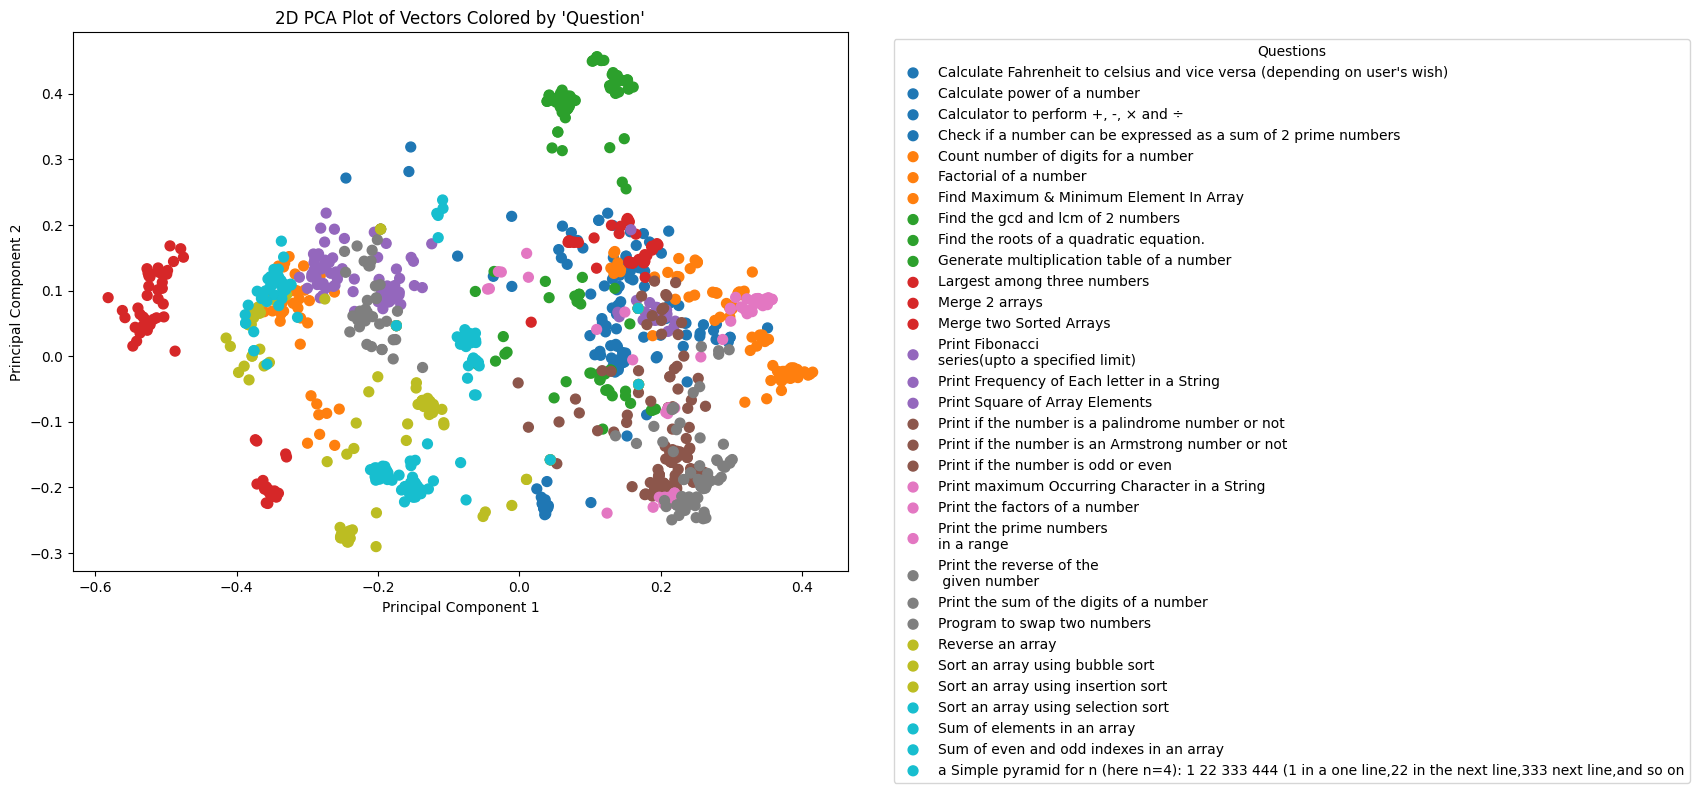

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the dataset
file_path = "og_visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns
vector_columns = [col for col in df.columns if "Vector_" in col]

# Extract all the vectors and questions
vectors = df[vector_columns].values
questions = df["Question"].values

# Reduce vectors to 2D using PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Get unique questions
unique_questions = np.unique(questions)

# Create a color map for each unique question
cmap = cm.get_cmap('tab10', len(unique_questions))  # Using 'tab10' colormap (up to 10 unique colors)

# Create a dictionary to map each question to a color
question_colors = {question: cmap(i) for i, question in enumerate(unique_questions)}

# Plot the vectors in 2D, colored by the Question
plt.figure(figsize=(10, 7))

# Scatter plot for each question with its associated color
for i, question in enumerate(unique_questions):
    # Filter vectors for the current question
    question_indices = np.where(questions == question)
    plt.scatter(vectors_2d[question_indices, 0], vectors_2d[question_indices, 1],
                c=[question_colors[question]] * len(question_indices[0]),
                marker='o', s=50, label=str(question))

# Add axis labels
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add title
plt.title("2D PCA Plot of Vectors Colored by 'Question'")

# Add legend
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


C:\Users\prana\AppData\Local\Temp\ipykernel_15056\2145802915.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_questions))  # Using 'tab10' colormap (up to 10 unique colors)


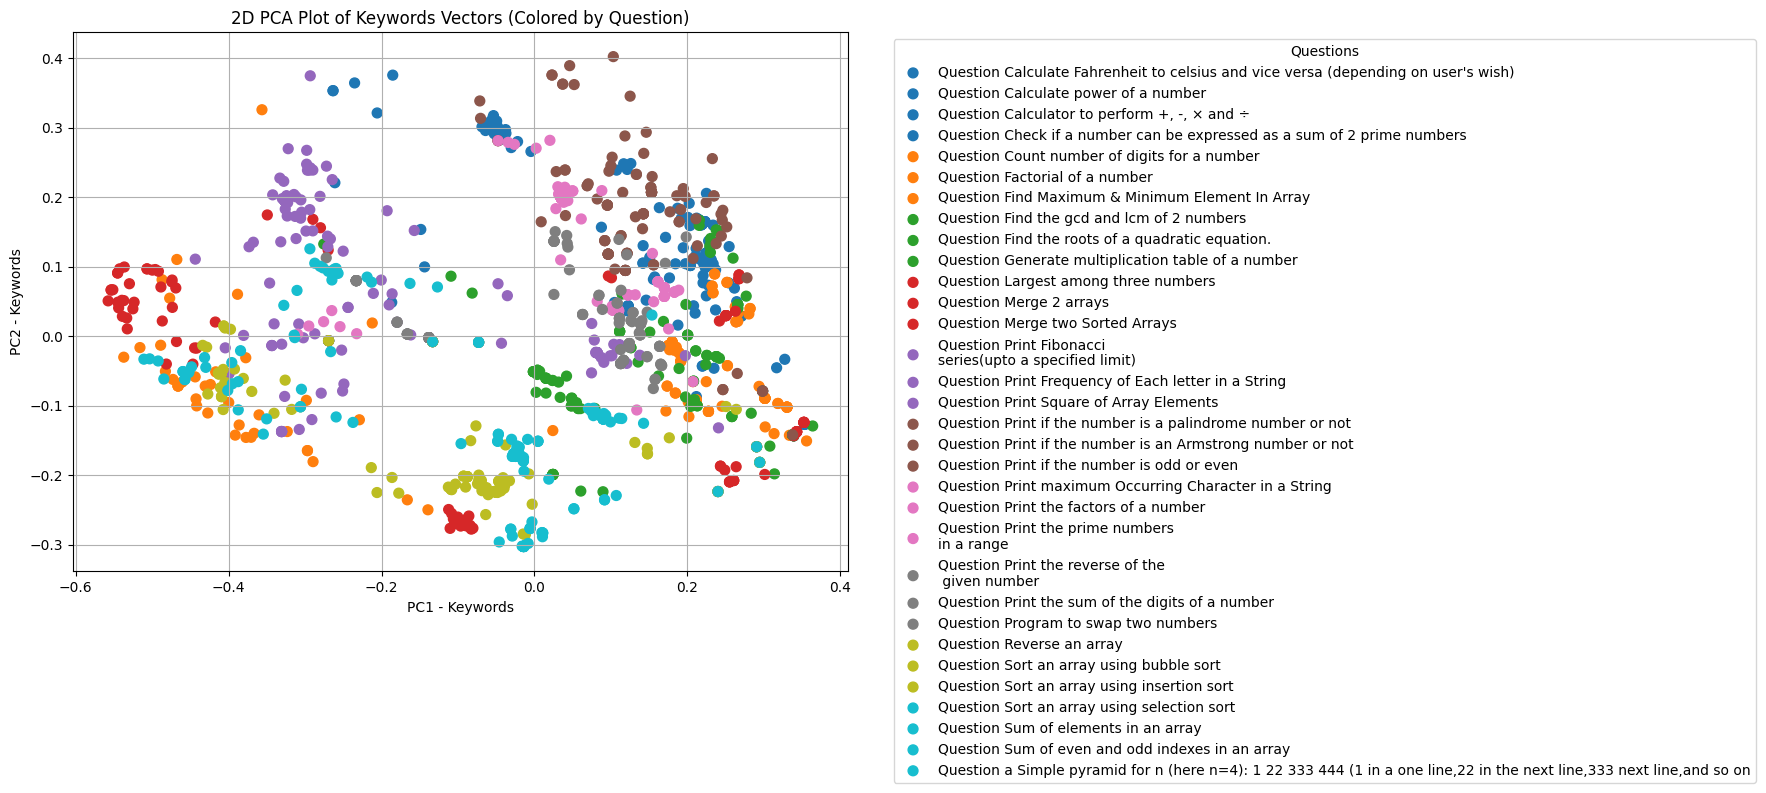

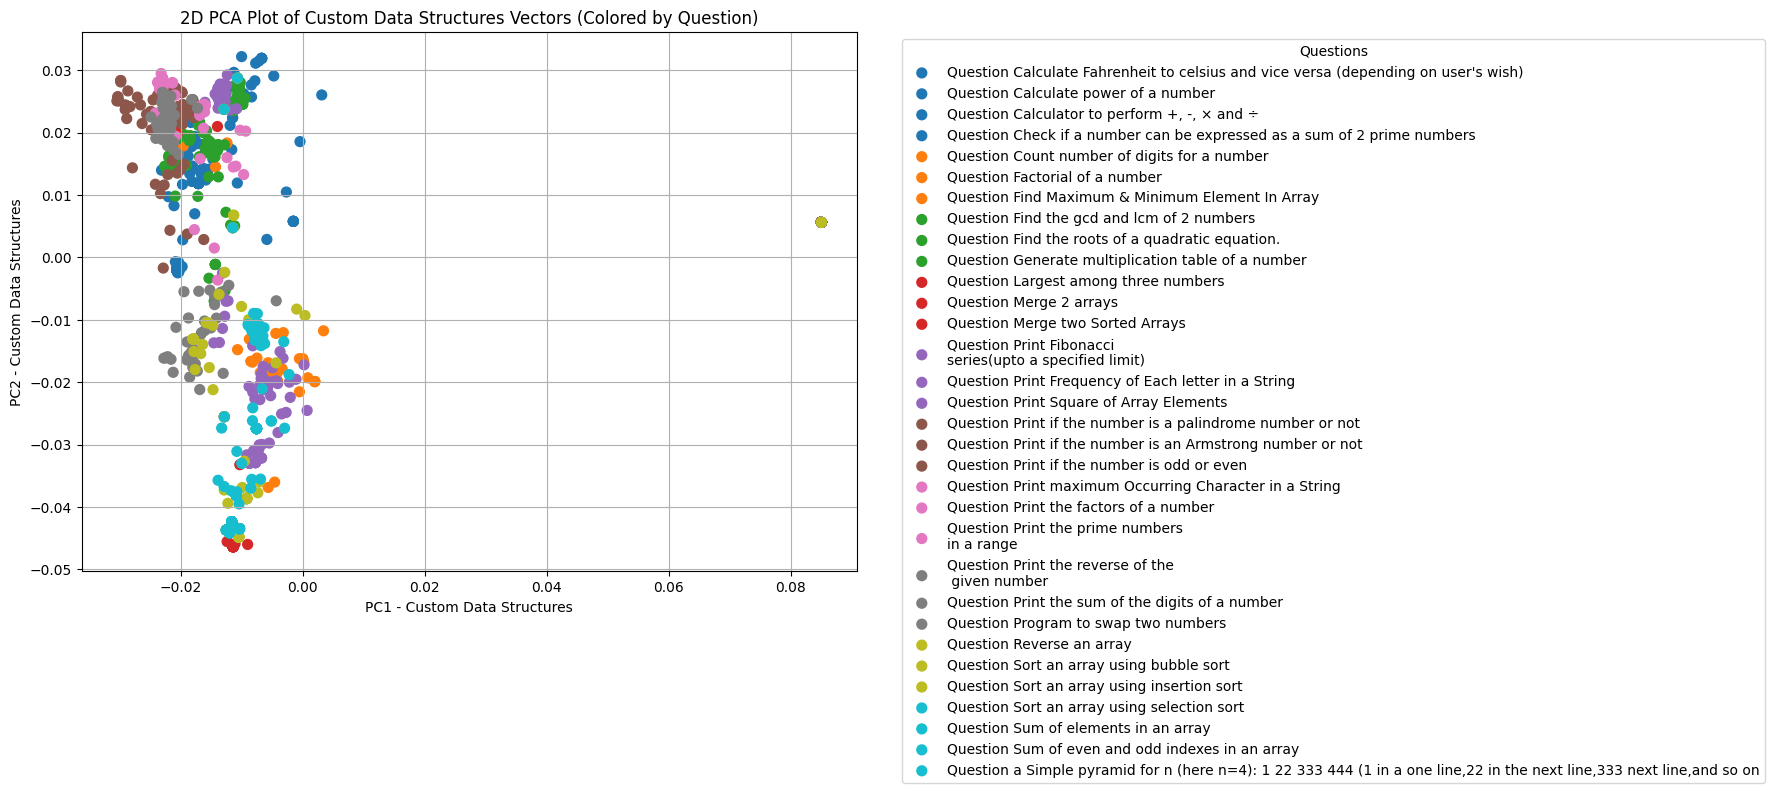

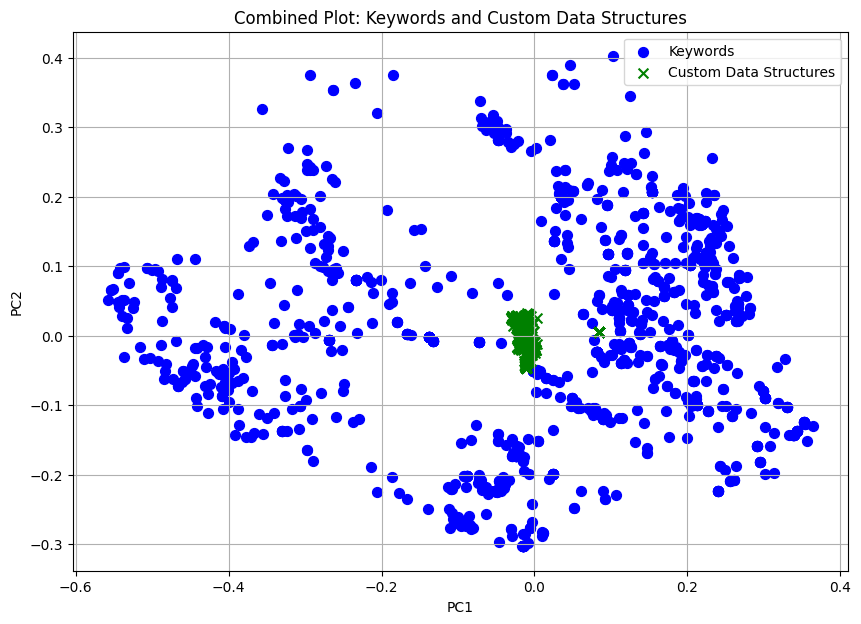

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract all rows of vector data
keywords_vectors = df[keywords_columns].values
custom_data_vectors = df[custom_data_columns].values
questions = df["Question"].values

# Reduce Keywords vectors to 2 dimensions using PCA
pca_keywords = PCA(n_components=2)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors)
reduced_keywords = reduced_keywords * 0.9
# Reduce Custom Data Structures vectors to 2 dimensions using PCA
pca_custom_data = PCA(n_components=2)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors)
reduced_custom_data = reduced_custom_data * 0.1

# Get unique questions
unique_questions = np.unique(questions)

# Create a color map for each unique question
cmap = cm.get_cmap('tab10', len(unique_questions))  # Using 'tab10' colormap (up to 10 unique colors)

# Create a dictionary to map each question to a color
question_colors = {question: cmap(i) for i, question in enumerate(unique_questions)}

# Plot for Keywords colored by Question
plt.figure(figsize=(10, 7))
for i, question in enumerate(unique_questions):
    # Filter indices where the question matches
    question_indices = np.where(questions == question)
    plt.scatter(reduced_keywords[question_indices, 0], reduced_keywords[question_indices, 1],
                c=[question_colors[question]] * len(question_indices[0]),
                marker='o', s=50, label=f'Question {question}')
plt.xlabel("PC1 - Keywords")
plt.ylabel("PC2 - Keywords")
plt.title("2D PCA Plot of Keywords Vectors (Colored by Question)")
plt.grid()
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot for Custom Data Structures colored by Question
plt.figure(figsize=(10, 7))
for i, question in enumerate(unique_questions):
    # Filter indices where the question matches
    question_indices = np.where(questions == question)
    plt.scatter(reduced_custom_data[question_indices, 0], reduced_custom_data[question_indices, 1],
                c=[question_colors[question]] * len(question_indices[0]),
                marker='o', s=50, label=f'Question {question}')
plt.xlabel("PC1 - Custom Data Structures")
plt.ylabel("PC2 - Custom Data Structures")
plt.title("2D PCA Plot of Custom Data Structures Vectors (Colored by Question)")
plt.grid()
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Combined Plot where Keywords and Custom Data Structures are added after scaling
plt.figure(figsize=(10, 7))
# Scatter plot for Keywords
plt.scatter(reduced_keywords[:, 0], reduced_keywords[:, 1], c='blue', marker='o', s=50, label='Keywords')
# Scatter plot for Custom Data Structures
plt.scatter(reduced_custom_data[:, 0], reduced_custom_data[:, 1], c='green', marker='x', s=50, label='Custom Data Structures')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Combined Plot: Keywords and Custom Data Structures")
plt.grid()
plt.legend()
plt.show()


C:\Users\prana\AppData\Local\Temp\ipykernel_9696\234207020.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_questions))  # Using 'tab10' colormap (up to 10 unique colors)


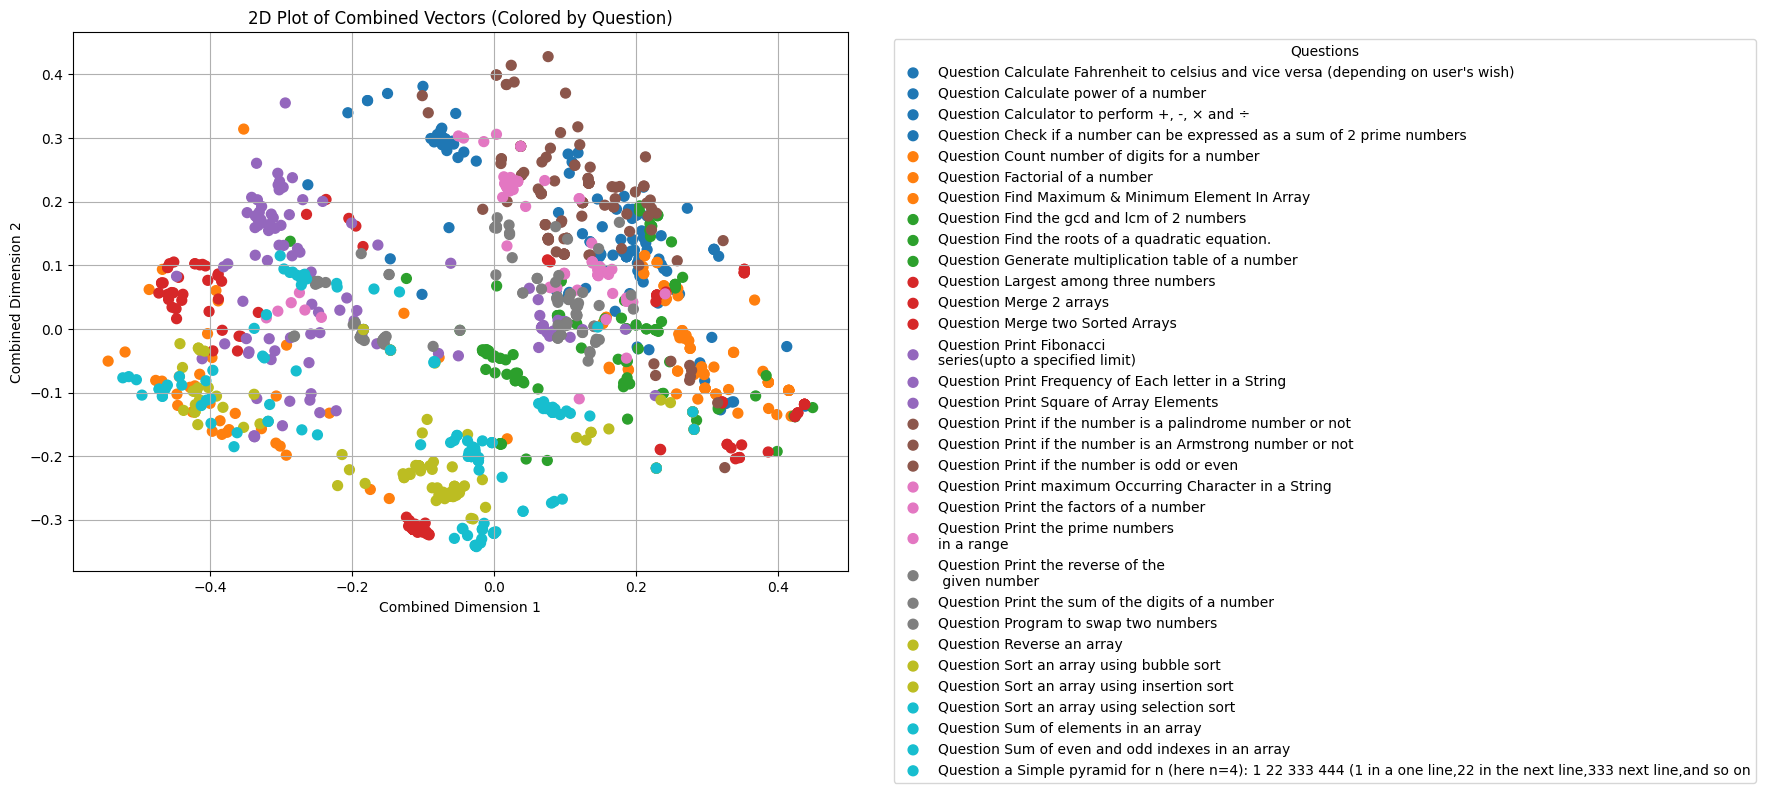

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm

# Load the dataset
file_path = "CE2__visu.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Identify vector columns for Keywords and Custom Data Structures
keywords_columns = [col for col in df.columns if "Keywords_Vector_" in col]
custom_data_columns = [col for col in df.columns if "Custom_Data_Structures_Vector_" in col]

# Extract all rows of vector data
keywords_vectors = df[keywords_columns].values
custom_data_vectors = df[custom_data_columns].values
questions = df["Question"].values

# Reduce Keywords vectors to 2 dimensions using PCA
pca_keywords = PCA(n_components=2)
reduced_keywords = pca_keywords.fit_transform(keywords_vectors) * 0.9  # Apply scaling

# Reduce Custom Data Structures vectors to 2 dimensions using PCA
pca_custom_data = PCA(n_components=2)
reduced_custom_data = pca_custom_data.fit_transform(custom_data_vectors) * 0.1  # Apply scaling

# Combine both reduced vectors (by adding them)
combined_2d = reduced_keywords + reduced_custom_data

# Get unique questions
unique_questions = np.unique(questions)

# Create a color map for each unique question
cmap = cm.get_cmap('tab10', len(unique_questions))  # Using 'tab10' colormap (up to 10 unique colors)

# Create a dictionary to map each question to a color
question_colors = {question: cmap(i) for i, question in enumerate(unique_questions)}

# Plot the combined 2D data colored by "Question"
plt.figure(figsize=(10, 7))
for i, question in enumerate(unique_questions):
    # Filter indices where the question matches
    question_indices = np.where(questions == question)
    plt.scatter(combined_2d[question_indices, 0], combined_2d[question_indices, 1],
                c=[question_colors[question]] * len(question_indices[0]),
                marker='o', s=50, label=f'Question {question}')

plt.xlabel("Combined Dimension 1")
plt.ylabel("Combined Dimension 2")
plt.title("2D Plot of Combined Vectors (Colored by Question)")

# Add legend with questions
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.grid()
plt.show()
